# Membership Inference over Diffusion-models-based Synthetic Tabular Data (MIDST) Challenge @ SaTML 2025.

## White Box Single Table Competition
Welcome to the MIDST challenge!

The MIDST challenge is a multi-track competition aiming to quantitatively evaluate the privacy of synthetic tabular data generated by diffusion models, with a specific focus on its resistance to membership inference attacks (MIAs).

This competition focuses on White Box MIA on tabular diffusion models trained on a single table transaction dataset. The schema of the transaction dataset is as follows:
| trans_id | account_id | trans_date | trans_type | operation | amount  | balance  | k_symbol | bank | account |
|----------|------------|------------|------------|-----------|---------|----------|----------|------|---------|
| integer  | integer    | integer    | integer    | integer   | float   | float    | integer  | integer | integer |

MIA will be performed over two state-of-the-art methods [TabSyn](https://arxiv.org/pdf/2310.09656) and [TabDDPM](https://arxiv.org/pdf/2209.15421). A collection of TabSyn and TabDDPM models will be trained on random subsets of the transaction dataset. The goal is to create an approach (MIA) that can distinguish between samples used to train a model (train data) and other data randomly sampled from the transaction dataset (holdout data) given the model and it's output synthetic data. The `final` set includes 20 models, each with its own set of challenge points (ie train and holdout data), to evaluate solutions on. To facilitate designing an attack, 30 `train` models are provided with comprehensive information about the model, training data and output synthetic data. Additionally, 20 `dev` models are provided to assist in evaluating the effectiveness of attacks prior to making a final submission to the `final` set. Participants can choose to perform MIA over one of or both TabSyn and TabDDPM. In the case of both, the attack that obtains the highest score will be used to rank the submission. A high level summary of the competition is below:
![wbox_diagram_final](https://github.com/user-attachments/assets/2ebb5eed-a6e3-433a-8769-4310b7fbc822)

This notebook will walk you through the process of creating and packaging a submission to the white box single table challenge.

## Package Imports and Evironment Setup

Ensure that you have installed the proper dependenices to run the notebook. The environment installation instructions are available [here](https://github.com/VectorInstitute/MIDSTModels/tree/main/starter_kits). Now that we have verfied we have the proper packages installed, lets import them and define global variables:

In [2]:
import csv
import os
import random
import zipfile

from pathlib import Path
from functools import partial
from typing import Callable, Any

import numpy as np
import torch

from tqdm.notebook import tqdm
from data import get_challenge_points
from metrics import get_tpr_at_fpr

In [3]:
TABDDPM_DATA_DIR = "tabddpm_white_box"
TABSYN_DATA_DIR = "tabsyn_white_box"

## Data

Next, lets download and extract the data for the competition:

In [ ]:
!gdown 1DGqz9U8IKLLZrhB3cKm0SEaoU_MyakKh
!unzip -qq -o tabddpm_white_box.zip

Downloading...
From (original): https://drive.google.com/uc?id=1DGqz9U8IKLLZrhB3cKm0SEaoU_MyakKh
From (redirected): https://drive.google.com/uc?id=1DGqz9U8IKLLZrhB3cKm0SEaoU_MyakKh&confirm=t&uuid=9d04494e-02aa-4135-9ea4-4f04fd654e68
To: /home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box.zip
 50%|███████████████████▋                   | 615M/1.22G [00:34<00:40, 14.8MB/s]^C
Traceback (most recent call last):
  File "/home/vidit/.cache/pypoetry/virtualenvs/midst-models-qGUjvEOx-py3.9/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/home/vidit/.cache/pypoetry/virtualenvs/midst-models-qGUjvEOx-py3.9/lib/python3.9/site-packages/gdown/__main__.py", line 172, in main
    download(
  File "/home/vidit/.cache/pypoetry/virtualenvs/midst-models-qGUjvEOx-py3.9/lib/python3.9/site-packages/gdown/download.py", line 368, in download
    for chunk in res.iter_content(chunk_size=CHUNK_SIZE):
  File "/home/vidit/.cache/pypoetry/virtualenvs/midst-models-qGUjvEOx-py3.9/lib/pyt

**Note:** If there is an issue with the download (ie throttled for downloading too many files with gdown) you can simply download the zip manually from this [link](https://drive.google.com/file/d/1DGqz9U8IKLLZrhB3cKm0SEaoU_MyakKh/view?usp=drive_link) and extract it in the same directory this notebook exists.

In [4]:
!gdown 1Os7f3l2A9SEdgB2V6oUK52k5U89MLTlb
!unzip -qq -o tabsyn_white_box.zip

Downloading...
From (original): https://drive.google.com/uc?id=1Os7f3l2A9SEdgB2V6oUK52k5U89MLTlb
From (redirected): https://drive.google.com/uc?id=1Os7f3l2A9SEdgB2V6oUK52k5U89MLTlb&confirm=t&uuid=1af2230a-24de-4909-8a73-9e6a7e6faad6
To: /home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabsyn_white_box.zip
100%|██████████████████████████████████████| 1.29G/1.29G [01:49<00:00, 11.8MB/s]


**Note:** If there is an issue with the download (ie throttled for downloading too many files with gdown) you can simply download the zip manually from this [link](https://drive.google.com/file/d/1Os7f3l2A9SEdgB2V6oUK52k5U89MLTlb/view?usp=drive_link) and extract it in the same directory this notebook exists.

### Contents
The archives extracted under the `tabddpm_white_box` and `tabsyn_white_box` each contain 3 subdirectories:

- `train`: Comprehensive information (ie model weights+architecture, training data, output synthetic data etc.) about the set of shadow models. Use these to develop your attacks without having to train your own models.
- `dev`: Set of challenge points. Membership predictions for these challenges will be used to evaluate submissions during the competition and update the live scoreboard in CodaBench.
- `final`: Set of challenge points. Membership predictions for these challenges will be used to evaluate submissions when the competition closes and to determine the final ranking.

The contents of the `train`, `dev` and `final` subdirectory of `tabddpm_white_box` and `tabsyn_white_box` slightly differ - this stems from the fact that each approach has its own set of artifacts from training. Below we outline the contents of the `train` for both TabSyn and TabDDPM along with the `dev` and `final` which include the same file types for each method.

<table> <tr> <th>Model - Stage</th> <th>File Name</th> <th>Description</th> </tr> <!-- TabDDPM - Train --> <tr> <td rowspan="8"><strong>TabDDPM - Train</strong></td> <td>train_with_id.csv</td> <td>Transaction samples used to train the model</td> </tr> <tr> <td>trans_domain.json</td> <td>Transaction data domain file indicating the domain information for each column</td> </tr> <tr> <td>challenge_with_id.csv</td> <td>Challenge points sampled from train data and holdout data</td> </tr> <tr> <td>challenge_label.csv</td> <td>The labels for the set of challenge points</td> </tr> <tr> <td>trans_label_encoders.pkl</td> <td>Pickled label encoders used in data preprocessing</td> </tr> <tr> <td>cluster_ckpt.pkl</td> <td>Pickled cluster checkpoint (Clustering does not impact training or sampling in single-table scenarios; the checkpoint exists solely because the multi-table pipeline was used for TabDDPM model.)</td> </tr> <tr> <td>None_trans_ckpt.pkl</td> <td>Pickled checkpoint of trained TabDDMP model</td> </tr> <tr> <td>trans_synthetic.csv</td> <td>Synthetic transaction data generated using the trained model</td> </tr> <!-- TabDDPM - Dev --> <tr> <td rowspan="6"><strong>TabDDPM - Dev</strong></td>  <tr> <td>challenge_with_id.csv</td> <td>Challenge points sampled from train data and holdout data</td> </tr> <!-- challenge_label.csv is excluded --> <tr> <td>trans_label_encoders.pkl</td> <td>Pickled label encoders used in data preprocessing</td> </tr>  <tr> <td>cluster_ckpt.pkl</td> <td>Pickled cluster checkpoint (Clustering does not impact training or sampling in single-table scenarios; the checkpoint exists solely because the multi-table pipeline was used for TabDDPM model.) </td> </tr> <tr> <td>None_trans_ckpt.pkl</td> <td>Pickled checkpoint of trained TabDDMP model</td> </tr> <tr> <td>trans_synthetic.csv</td> <td>Synthetic data output from the trained model</td></tr> <!-- TabDDPM - Eval --> <tr> <td rowspan="6"><strong>TabDDPM - Final</strong></td> </tr> <tr> <td>challenge_with_id.csv</td> <td>Challenge points sampled from train data and holdout data</td> </tr> <tr> <td>trans_label_encoders.pkl</td> <td>Pickled label encoders used in data preprocessing</td> </tr> <tr> <td>cluster_ckpt.pkl</td> <td>Pickled cluster checkpoint (Clustering does not impact training or sampling in single-table scenarios; the checkpoint exists solely because the multi-table pipeline was used for TabDDPM model.)</td> </tr> <tr> <td>None_trans_ckpt.pkl</td> <td>Pickled checkpoint of trained TabDDMP model</td> </tr> <tr> <td>trans_synthetic.csv</td> <td>Synthetic transaction data generated using the trained model</td> </tr> <!-- TabSyn - Train --> <tr> <td rowspan="6"><strong>TabSyn - Train</strong></td> <td>train_with_id.csv</td> <td>Transaction samples used to train the model</td> </tr> <tr> <td>challenge_with_id.csv</td> <td>Challenge points sampled from train data and holdout data</td> </tr> <tr> <td>challenge_label.csv</td> <td>The labels for the set of challenge points</td> </tr> <tr> <td>model.pt</td> <td>Pickled checkpoint of trained diffusion model of Tabsyn</td> </tr> <tr> <td>vae/</td> <td>Model artifacts for trained VAE model of TabSyn</td> </tr> <tr> <td>trans_synthetic.csv</td> <td>Synthetic transaction data generated using the trained model</td> </tr> <!-- TabSyn - Dev --> <tr> <td rowspan="5"><strong>TabSyn - Dev</strong></td> </tr> <tr> <td>challenge_with_id.csv</td> <td>Challenge points sampled from train data and holdout data</td> </tr> <tr> <td>model.pt</td> <td>Pickled checkpoint of trained diffusion model of Tabsyn</td> </tr> <tr> <td>vae/</td> <td>Model artifacts for trained VAE model of TabSyn</td> </tr> <tr> <td>trans_synthetic.csv</td> <td>Synthetic transaction data generated using the trained model</td> </tr> <!-- TabSyn - Eval --> <tr> <td rowspan="5"><strong>TabSyn - Final</strong></td> </tr> <tr> <td>challenge_with_id.csv</td> <td>Challenge points sampled from train data and holdout data</td> </tr> <tr> <td>model.pt</td> <td>Pickled checkpoint of trained diffusion model of Tabsyn</td> </tr> <tr> <td>vae/</td> <td>Model artifacts for trained VAE model of TabSyn</td> </tr> <tr> <td>trans_synthetic.csv</td> <td>Synthetic transaction data generated using the trained model</td> </tr> </table>


## Task

Your task as a competitor is to produce, for each model in `dev` and `final` in `tabddpm_white_box` and `tabsyn_white_box`, a CSV file listing your confidence scores (values between 0 and 1) for the membership of the challenge examples. You must save these scores in a `prediction.csv` file and place it in the same folder as the corresponding model. A submission to the challenge is an an archive containing just these `prediction.csv` files.

**You must submit predictions for both `dev` and `final` when you submit to CodaBench.**

In the following, we will show you how to correctly package a submission to the competition. To focus solely on the submission logic, the attack model will simply generate random predictions. Let's start by creating baseline attack models `tabddpm_attack_model` and `tabsyn_attack_model` based on their respective shadow models:

In [4]:
def get_attack_model(base_train_path: Path) -> Callable[[Any], float]:
    return lambda x : random.uniform(0, 1)

base_tabddpm_train_path = os.path.join(TABDDPM_DATA_DIR, "train")
base_tabsyn_train_path = os.path.join(TABSYN_DATA_DIR, "train")
tabddpm_attack_model = get_attack_model(base_tabddpm_train_path)
tabsyn_attack_model = get_attack_model(base_tabsyn_train_path)

Using the attack model, we can obtain predictions for each point in the challenge point set for train, dev and final:

In [5]:
phases = ["train", "dev", "final"]

for base_dir, attack_model in zip([TABDDPM_DATA_DIR, TABSYN_DATA_DIR], [tabddpm_attack_model, tabsyn_attack_model]):
    for phase in phases:
        root = os.path.join(base_dir, phase)
        model_folders = [item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item))]
        for model_folder in sorted(model_folders, key=lambda d: int(d.split('_')[1])):
            path = os.path.join(root, model_folder)
    
            challenge_points = get_challenge_points(path)
    
            predictions = torch.Tensor([attack_model(cp) for cp in challenge_points])
           
            assert torch.all((0 <= predictions) & (predictions <= 1))
            with open(os.path.join(path, "prediction.csv"), mode="w", newline="") as file:
                writer = csv.writer(file)
    
                # Write each value in a separate row
                for value in list(predictions.numpy().squeeze()):
                    writer.writerow([value])

## Scoring

Let's see how the attack does on `train`, for which we have the ground truth.
When preparing a submission, you can use part of `train` to develop an attack and a held-out part to evaluate your attack.

In [6]:
tpr_at_fpr_list = []
for base_dir in [TABDDPM_DATA_DIR, TABSYN_DATA_DIR]:
    predictions = []
    solutions  = []
    root = os.path.join(base_dir, "train")
    model_folders = [item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item))]
    for model_folder in sorted(model_folders, key=lambda d: int(d.split('_')[1])):
        path = os.path.join(root, model_folder)
        predictions.append(np.loadtxt(os.path.join(path, "prediction.csv")))
        solutions.append(np.loadtxt(os.path.join(path, "challenge_label.csv"), skiprows=1))
    
    predictions = np.concatenate(predictions)
    solutions = np.concatenate(solutions)
    
    tpr_at_fpr = get_tpr_at_fpr(solutions, predictions)
    tpr_at_fpr_list.append(tpr_at_fpr)
    
    print(f"{base_dir.split('_')[0]} Train Attack TPR at FPR==10%: {tpr_at_fpr}")

final_tpr_at_fpr = max(tpr_at_fpr_list)
print(f"Final Train Attack TPR at FPR==10%: {final_tpr_at_fpr}")

tabddpm Train Attack TPR at FPR==10%: 0.09933333333333333
tabsyn Train Attack TPR at FPR==10%: 0.099
Final Train Attack TPR at FPR==10%: 0.09933333333333333


## Packaging the submission

Now we can store the predictions into a zip file, which you can submit to CodaBench. Importantly, we create a single zip file for dev and final. The structure of the submission is as follows:

```
└── root_folder
    ├── tabsyn_white_box
    │   ├── dev
    │   │   └── tabsyn_#
    │   │       └── prediction.csv
    │   └── final
    │       └── tabsyn_#
    │           └── prediction.csv
    └── tabddpm_white_box
        ├── dev 
        │   └── tabddpm_#
        │       └── prediction.csv
        └── final 
            └── tabddpm_# 
                └── prediction.csv
```
**Note:** The `root_folder` can have any name but it is important all of the subdirectories follow the above structure and naming conventions. 

If a participant is looking to submit an attack for only one of TabSyn and TabDDPM, they can simply omit the other directory (ie `tabddpm_white_box` or `tabsyn_white_box` from the root_folder).

In [7]:
with zipfile.ZipFile(f"white_box_single_table_submission.zip", 'w') as zipf:
    for phase in ["dev", "final"]:
        for base_dir in [TABDDPM_DATA_DIR, TABSYN_DATA_DIR]:
            root = os.path.join(base_dir, phase)
            model_folders = [item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item))]
            for model_folder in sorted(model_folders, key=lambda d: int(d.split('_')[1])):
                path = os.path.join(root, model_folder)
                if not os.path.isdir(path): continue

                file = os.path.join(path, "prediction.csv")
                if os.path.exists(file):
                    # Use `arcname` to remove the base directory and phase directory from the zip path
                    arcname = os.path.relpath(file, os.path.dirname(base_dir))
                    zipf.write(file, arcname=arcname)
                else:
                    raise FileNotFoundError(f"`prediction.csv` not found in {path}.")

The generated white_box_single_table_submission.zip can be directly submitted to the dev phase in the CodaBench UI. Although this submission contains your predictions for both the dev and final set, you will only receive feedback on your predictions for the dev phase. The predictions for the final phase will be evaluated once the competiton ends using the most recent submission to the dev phase.

In [8]:
import json

from midst_models.single_table_TabDDPM.wb_complex_pipeline import (
    clava_clustering,
    clava_training,
    clava_load_pretrained,
    clava_synthesizing,
    load_configs,
)
from midst_models.single_table_TabDDPM.wb_pipeline_modules import load_multi_table
from midst_models.single_table_TabDDPM.tab_ddpm.gaussian_multinomial_diffsuion import GaussianMultinomialDiffusion

In [11]:
!pwd

/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits


In [9]:
# Load config
config_path = "/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1/trans.json"
configs, save_dir = load_configs(config_path)

# Display config
json_str = json.dumps(configs, indent=4)
print(json_str)

{
    "general": {
        "data_dir": "/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1",
        "exp_name": "",
        "workspace_dir": "/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1",
        "sample_prefix": "",
        "test_data_dir": "/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1"
    },
    "clustering": {
        "parent_scale": 1.0,
        "num_clusters": 50,
        "clustering_method": "both"
    },
    "diffusion": {
        "d_layers": [
            512,
            1024,
            1024,
            1024,
            1024,
            512
        ],
        "dropout": 0.0,
        "num_timesteps": 2000,
        "model_type": "mlp",
        "iterations": 200000,
        "batch_size": 4096,
        "lr": 0.0006,
        "gaussian_loss_type": "mse",
        "weight_decay": 1e-05,
        "scheduler": "cosine"
    },
    "classifier": {
        "d_layers": [


In [10]:
relation_order = [[None, 'trans']]

In [11]:
models = clava_load_pretrained(relation_order, save_dir)

None -> trans checkpoint found, loading...


/home/vidit/.cache/pypoetry/virtualenvs/midst-models-qGUjvEOx-py3.9/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/vidit/.cache/pypoetry/virtualenvs/midst-models-qGUjvEOx-py3.9/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator QuantileTransformer from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:
models

{(None,
  'trans'): {'diffusion': GaussianMultinomialDiffusion(
    (_denoise_fn): MLPDiffusion(
      (mlp): MLP(
        (blocks): ModuleList(
          (0): Block(
            (linear): Linear(in_features=128, out_features=512, bias=True)
            (activation): ReLU()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (1): Block(
            (linear): Linear(in_features=512, out_features=1024, bias=True)
            (activation): ReLU()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (2): Block(
            (linear): Linear(in_features=1024, out_features=1024, bias=True)
            (activation): ReLU()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (3): Block(
            (linear): Linear(in_features=1024, out_features=1024, bias=True)
            (activation): ReLU()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (4): Block(
            (linear): Linear(in_features=1024, o

In [13]:
type(models[(None,'trans')]['diffusion'])

midst_models.single_table_TabDDPM.tab_ddpm.gaussian_multinomial_diffsuion.GaussianMultinomialDiffusion

In [14]:
model = models[(None,'trans')]['diffusion']
model

GaussianMultinomialDiffusion(
  (_denoise_fn): MLPDiffusion(
    (mlp): MLP(
      (blocks): ModuleList(
        (0): Block(
          (linear): Linear(in_features=128, out_features=512, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (1): Block(
          (linear): Linear(in_features=512, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (2): Block(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (3): Block(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (4): Block(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dro

In [15]:
models[(None,'trans')]["diffusion"]._denoise_fn

MLPDiffusion(
  (mlp): MLP(
    (blocks): ModuleList(
      (0): Block(
        (linear): Linear(in_features=128, out_features=512, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (1): Block(
        (linear): Linear(in_features=512, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (2): Block(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (3): Block(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (4): Block(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (5): Block(
        (linear): Linear(in_features=1024, out

In [16]:
device = "cuda"

In [17]:
model.to(device)

GaussianMultinomialDiffusion(
  (_denoise_fn): MLPDiffusion(
    (mlp): MLP(
      (blocks): ModuleList(
        (0): Block(
          (linear): Linear(in_features=128, out_features=512, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (1): Block(
          (linear): Linear(in_features=512, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (2): Block(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (3): Block(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (4): Block(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dro

In [11]:
def compute_t_error(model, x, t):
    """
    Computes the reconstruction error at a specific timestep t.

    Args:
        model: Pretrained GaussianMultinomialDiffusion model.
        x: Input data tensor.
        t: Diffusion timestep (int or tensor).

    Returns:
        Reconstruction error tensor for each sample in x.
    """
    # l = [2.1900000e+03, 2.0000000e+00, 5.0000000e+00, 8.0100000e+04,
    #    1.4015810e+05, 8.0000000e+00, 1.3000000e+01, 9.7259157e+07] # this list was supposed to be the max values in each coulmn of challenge_with_id

    #l = torch.tensor(l).to(device="cuda")
    # Simulate the diffusion process
    #x = x/l 
    
    x_t = model.gaussian_q_sample(x_start=x, t=torch.tensor([t] * len(x)).to(x.device))
    
    #x_t = x_t/l
    # Perform reverse denoising
    x_recon = model._denoise_fn(x_t, torch.tensor([t] * len(x)).to(x.device))
    
    # Compute reconstruction error (e.g., L2 norm)
    t_error = torch.norm(x - x_recon, p=2, dim=1)
    return t_error


In [18]:
def compute_t_error(model, x, t):
    """
    Computes the reconstruction error at a specific timestep t.

    Args:
        model: Pretrained GaussianMultinomialDiffusion model.
        x: Input data tensor.
        t: Diffusion timestep (int or tensor).

    Returns:
        Reconstruction error tensor for each sample in x.
    """
    column_var = torch.tensor([ 2.6176e+05, 9.3693e-01, 2.5482e+00, 9.0376e+07,
        4.8698e+08, 7.0646e+00, 1.3100e+01, 6.8835e+14], dtype=torch.float64).to(device = 'cuda')
    column_std = torch.sqrt(column_var).to(device = 'cuda')
    column_means = torch.tensor([ 1.4638e+03, 1.2178e+00, 2.4518e+00, 5.9199e+03,
        3.8463e+04, 3.3334e+00, 1.8213e+00, 1.2850e+07], dtype=torch.float64).to(device= 'cuda')

    # Simulate the diffusion process
  
    
    x_t = model.gaussian_q_sample(x_start=x, t=torch.tensor([t] * len(x)).to(x.device))
    x_recon = model._denoise_fn(x_t, torch.tensor([t] * len(x)).to(x.device))

    x = (x - column_means)/column_std 
    x_recon = (x_recon - column_means)/column_std 
   
    # Compute reconstruction error (e.g., L2 norm)
    t_error = torch.norm(x - x_recon, p=2, dim=1)
    return t_error


In [19]:
model._denoise_fn   

MLPDiffusion(
  (mlp): MLP(
    (blocks): ModuleList(
      (0): Block(
        (linear): Linear(in_features=128, out_features=512, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (1): Block(
        (linear): Linear(in_features=512, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (2): Block(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (3): Block(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (4): Block(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (5): Block(
        (linear): Linear(in_features=1024, out

In [20]:
import torch
import torch.nn as nn

class QuantileRegressor(nn.Module):
    def __init__(self, input_dim_original, input_dim_timesteps, aggregator_hidden_dim=16, regressor_hidden_dims=[128, 64, 32]):
        """
        QuantileRegressor with dual inputs:
        - Original input value (feature vector).
        - Reconstruction errors across timesteps.

        Args:
        - input_dim_original (int): Dimension of the original input feature vector.
        - input_dim_timesteps (int): Number of timesteps (features for reconstruction errors).
        - aggregator_hidden_dim (int): Number of neurons in the Weighted Aggregator's hidden layer.
        - regressor_hidden_dims (list): Hidden layer dimensions for the regression network.
        """
        super(QuantileRegressor, self).__init__()

        # Weighted Aggregator for reconstruction errors
        self.aggregator = nn.Sequential(
            nn.Linear(input_dim_timesteps, aggregator_hidden_dim),
            nn.ReLU(),
            nn.Linear(aggregator_hidden_dim, 1)  # Outputs a single aggregated scalar value
        )

        # Fully connected layers for the original input
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim_original, regressor_hidden_dims[0]),
            nn.ReLU(),
        )

        # Final regression network
        regressor_input_dim = regressor_hidden_dims[0] + 1  # Combine extracted features and aggregated errors
        layers = []
        for i in range(1, len(regressor_hidden_dims)):
            layers.append(nn.Linear(regressor_input_dim if i == 1 else regressor_hidden_dims[i - 1], regressor_hidden_dims[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))  # Dropout for regularization
        layers.append(nn.Linear(regressor_hidden_dims[-1], 1))  # Final output layer
        self.regressor = nn.Sequential(*layers)

    def forward(self, x_original, x_errors):
        """
        Forward pass with dual inputs.

        Args:
        - x_original (torch.Tensor): Input tensor for original features, shape (batch_size, input_dim_original).
        - x_errors (torch.Tensor): Input tensor for reconstruction errors, shape (batch_size, input_dim_timesteps).

        Returns:
        - torch.Tensor: Output tensor of shape (batch_size, 1), predicted quantile threshold.
        """
        # Aggregate reconstruction errors
        aggregated_errors = self.aggregator(x_errors)  # Shape: (batch_size, 1)

        # Extract features from the original input
        extracted_features = self.feature_extractor(x_original)  # Shape: (batch_size, hidden_dim)

        # Concatenate aggregated errors and extracted features
        combined_input = torch.cat([aggregated_errors, extracted_features], dim=1)  # Shape: (batch_size, regressor_input_dim)

        # Pass through the final regressor
        output = self.regressor(combined_input)  # Shape: (batch_size, 1)
        return output



In [307]:
# from torch import nn, optim
# import matplotlib.pyplot as plt


# def train_quantile_regressor(model, data, labels, alpha, epochs=200, lr=0.001):
#     """
#     Train a quantile regression model with pinball loss.
#     """
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     # Move data and labels to the same device as the model
#     data = data.to(device)
#     labels = labels.to(device)
#     model = model.to(device)

#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     criterion = lambda y_pred, y: torch.mean((y_pred - y) * ((y <= y_pred).float() - alpha))
#     losses = []

#     for epoch in range(epochs):
#         model.train()
#         optimizer.zero_grad()
#         outputs = model(data)
#         loss = criterion(outputs.squeeze(), labels)
#         losses.append(loss.item())
#         loss.backward()
#         optimizer.step()
    
#     plt.figure(figsize=(8, 5))
#     plt.plot(range(1, epochs + 1), losses, label='Training Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title('Training Loss Over Epochs')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

In [29]:
import matplotlib.pyplot as plt
def train_bagged_regressors(data_original, data_errors, num_models=5, alpha=0.05, epochs=50, lr=0.001):
    """
    Train multiple quantile regressors in an unsupervised manner by learning the distribution of reconstruction errors.

    Args:
    - data_original (torch.Tensor): Original input tensor, shape (num_samples, input_dim_original).
    - data_errors (torch.Tensor): Reconstruction errors, shape (num_samples, input_dim_timesteps).
    - num_models (int): Number of models in the bagging ensemble.
    - alpha (float): Quantile level (e.g., 0.05 for 5% quantile).
    - epochs (int): Number of training epochs per regressor.
    - lr (float): Learning rate for the optimizer.
    """
    data_errors = data_errors.to(data_original.device)  # Ensure errors are on the same device
    models = []

    for i in range(num_models):
        print(f"Training model {i + 1}/{num_models} on GPU...")

        # Bootstrap sampling for unsupervised quantile learning
        indices = torch.randint(0, len(data_original), (len(data_original),), device=data_original.device)
        bootstrap_original = data_original[indices]
        bootstrap_errors = data_errors[indices]  # Subset reconstruction errors

        # Initialize the model
        input_dim_original = data_original.shape[1]
        input_dim_timesteps = data_errors.shape[0]
        model = QuantileRegressor(input_dim_original, input_dim_timesteps).to(data_original.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Define pinball loss for self-supervised quantile learning
        criterion = lambda y_pred, y_true: torch.mean((y_pred - y_true) * ((y_true <= y_pred).float() - alpha))
        losses = []

        # Training loop
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            # Forward pass
            outputs = model(bootstrap_original, bootstrap_errors)

            # Use reconstruction errors as pseudo-targets for unsupervised training
            loss = criterion(outputs.squeeze(), bootstrap_errors.mean(dim=1))  # Fit to the mean distribution of errors
            losses.append(loss.item())

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        models.append(model)

        # Plot the training loss
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, epochs + 1), losses, label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()
    return models




def aggregate_predictions(models, data):
    """
    Aggregate predictions from bagged regressors using averaging.
    """
    predictions = torch.stack([model(data).squeeze() for model in models], dim=0)
    return predictions.mean(dim=0)  # Averaging predictions


In [30]:
def perform_membership_inference(models, x, threshold_alpha):
    """
    Perform membership inference using reconstruction errors and a quantile regression model.
    """
    errors = compute_t_error(model, x, t=5)  # Example timestep
    thresholds = models(x)
    predictions = (errors <= thresholds).float()  # Membership decision
    return predictions


In [31]:
!pwd

/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1


In [32]:
cd tabddpm_white_box/train/tabddpm_1

[Errno 2] No such file or directory: 'tabddpm_white_box/train/tabddpm_1'
/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1


/home/vidit/.cache/pypoetry/virtualenvs/midst-models-qGUjvEOx-py3.9/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [33]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the datasets
train_data = pd.read_csv("train_with_id.csv")
synthetic_data = pd.read_csv("trans_synthetic.csv")
challenge_data = pd.read_csv("challenge_with_id.csv")
challenge_labels = pd.read_csv("challenge_label.csv")

# Extract data and IDs
train_features = train_data.drop(columns=["trans_id",'account_id']).values
#train_features = train_features.drop(columns=["account_id"]).values
synthetic_features = synthetic_data.values
challenge_features = challenge_data.drop(columns=["trans_id","account_id"]).values
challenge_ground_truth = challenge_labels["is_train"].values

# Normalize the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
synthetic_features = scaler.transform(synthetic_features)
challenge_features = scaler.transform(challenge_features)
challenge_tensor = torch.tensor(challenge_features, dtype=torch.float32).to(device)

In [34]:
challenge_ground_truth

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1])

In [26]:
# Split synthetic data into training and validation sets
#synthetic_train, synthetic_val_ = train_test_split(train_features, test_size=0.2, random_state=42) # wrong as validation dataset same as training data

synthetic_train = train_features
synthetic_val = challenge_features

# Compute reconstruction errors for synthetic data
def compute_reconstruction_errors(data, model, t):
    errors = []
    for x in torch.tensor(data, dtype=torch.float32).to(device):
        x = x.unsqueeze(0)  # Add batch dimension
        error = compute_t_error(model, x, t)
        errors.append(error.item())
    return torch.tensor(errors, dtype=torch.float32)

# Reconstruction errors for synthetic training and validation data
synthetic_train_errors = compute_reconstruction_errors(synthetic_train, model, t=10)
synthetic_val_errors = compute_reconstruction_errors(synthetic_val, model, t=10)

In [35]:
input_dim = synthetic_train.shape[1]
synthetic_train_tensor = torch.tensor(synthetic_train, dtype=torch.float32).to(device)

# Train bagged quantile regressors
num_bagged_models = 20  # Number of models in the ensemble
bagged_models = train_bagged_regressors(synthetic_train_tensor, synthetic_train_errors, num_models=num_bagged_models,alpha=0.10, epochs=100, lr=0.005)

Training model 1/20 on GPU...


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [28]:
# Compute reconstruction errors for challenge data
challenge_errors = compute_reconstruction_errors(challenge_features, model, t=10)

# Perform membership inference
challenge_tensor = torch.tensor(challenge_features, dtype=torch.float32).to(device)
#predicted_thresholds = quantile_regressor(challenge_tensor).squeeze().cpu().detach()
predicted_thresholds = aggregate_predictions(bagged_models, challenge_tensor).cpu().detach().numpy()
#membership_predictions = (challenge_errors <= predicted_thresholds).float().cpu().numpy()
# Ensure both are tensors for comparison
predicted_thresholds = torch.tensor(predicted_thresholds).to(challenge_errors.device)
membership_predictions = (challenge_errors <= predicted_thresholds).float().cpu().numpy()




from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

# Compute evaluation metrics
accuracy = accuracy_score(challenge_ground_truth, membership_predictions)
# precision = precision_score(challenge_ground_truth, membership_predictions)
# recall = recall_score(challenge_ground_truth, membership_predictions)
auc = roc_auc_score(challenge_ground_truth, membership_predictions)

print(f"Membership Inference Attack Metrics:")
print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(challenge_ground_truth, challenge_errors)

# Find the threshold where FPR is closest to 0.1
fpr_target = 0.1
idx = (fpr <= fpr_target).sum() - 1  # Find the index of the last FPR <= 0.1
tpr_at_fpr_target = tpr[idx] if idx >= 0 else 0

print(f"True Positive Rate at 10% False Positive Rate: {tpr_at_fpr_target:.4f}")


NameError: name 'bagged_models' is not defined

In [296]:
challenge_errors

tensor([18.5745, 20.7480, 13.7084, 21.3807, 13.9951, 15.5741, 21.4933, 12.7349,
        15.8652, 17.7508, 15.3812, 15.9109, 19.3794, 14.2916, 22.3399, 17.5960,
        19.3326, 23.0183, 18.1111, 20.7264, 15.2792, 18.0319, 14.7540, 21.5136,
        21.1013, 19.9186, 14.9028, 12.5328, 14.4762, 12.6598, 14.1960, 13.2329,
        12.8555, 20.0975, 14.3212, 22.5773, 19.6891, 23.2481, 15.3616, 21.6785,
        20.7733, 18.5458, 16.5207, 21.4945, 14.7241, 19.4310, 16.1904, 16.8834,
        20.1798, 15.3482, 22.7377, 18.8161, 13.8230, 23.6567, 10.8636, 15.2023,
        12.4954, 14.6899, 15.8066, 12.9417, 25.6228, 12.2435, 14.5903, 21.1665,
        20.7586, 16.0594, 21.0423, 13.4660, 21.3224, 21.6987, 21.7729, 15.1495,
        20.2740, 19.8934, 16.0387, 12.6803, 15.5364, 21.0802, 11.1309, 15.1501,
        14.7921, 15.2484, 19.8780, 20.7168, 21.2603, 12.7607, 14.6484, 12.0326,
        14.2065, 15.7755, 22.1960, 14.8562, 15.1558, 18.6920, 29.6040, 16.5828,
        14.4490, 15.1677, 13.7322, 13.91

In [297]:
predicted_thresholds

tensor([14.0696, 19.4168, 11.4867, 21.6034, 10.4242, 12.8608, 19.7439, 11.3630,
        13.9048, 15.9952, 12.5485, 13.6659, 14.5889, 12.8597, 19.2054, 15.6816,
        16.8249, 21.7795, 14.5097, 17.1077, 12.3516, 15.4884, 13.5770, 17.9079,
        18.0875, 20.8959, 12.7317, 11.8346, 11.9168, 11.5396, 10.4881, 11.2185,
        11.4479, 14.5573, 10.9818, 22.7937, 14.4315, 20.2667, 13.7973, 18.3578,
        17.4324, 14.1134, 13.7430, 19.2783, 12.6261, 14.2991, 14.2354, 12.5761,
        17.6204, 13.8843, 22.2338, 15.9503, 11.7920, 17.1450, 10.1519, 13.0105,
        11.6514, 12.0498, 14.4026, 11.8731, 23.3913,  9.1842, 11.2819, 17.6820,
        18.9597, 12.3359, 18.6072, 12.4744, 18.4361, 15.6237, 18.3506, 13.6850,
        12.2645, 16.1430, 12.6863, 11.1795, 11.9523, 17.6298,  9.8854, 11.8244,
        12.9515, 13.6125, 12.3036, 18.2722, 19.5392, 11.0864, 12.6633, 11.2905,
        11.8868, 12.7239, 18.5328, 13.6086, 12.2376, 15.4545, 18.8444, 14.1986,
        12.3597, 13.2618, 11.2576, 12.41

In [298]:
predicted_thresholds - challenge_errors

tensor([-4.5049e+00, -1.3312e+00, -2.2216e+00,  2.2273e-01, -3.5709e+00,
        -2.7133e+00, -1.7495e+00, -1.3718e+00, -1.9604e+00, -1.7556e+00,
        -2.8327e+00, -2.2450e+00, -4.7905e+00, -1.4319e+00, -3.1345e+00,
        -1.9144e+00, -2.5077e+00, -1.2388e+00, -3.6014e+00, -3.6187e+00,
        -2.9277e+00, -2.5435e+00, -1.1770e+00, -3.6057e+00, -3.0138e+00,
         9.7727e-01, -2.1711e+00, -6.9821e-01, -2.5594e+00, -1.1202e+00,
        -3.7079e+00, -2.0145e+00, -1.4077e+00, -5.5403e+00, -3.3394e+00,
         2.1638e-01, -5.2576e+00, -2.9814e+00, -1.5644e+00, -3.3207e+00,
        -3.3409e+00, -4.4323e+00, -2.7776e+00, -2.2162e+00, -2.0981e+00,
        -5.1319e+00, -1.9549e+00, -4.3072e+00, -2.5594e+00, -1.4639e+00,
        -5.0395e-01, -2.8658e+00, -2.0310e+00, -6.5118e+00, -7.1172e-01,
        -2.1918e+00, -8.4400e-01, -2.6401e+00, -1.4039e+00, -1.0687e+00,
        -2.2316e+00, -3.0593e+00, -3.3084e+00, -3.4845e+00, -1.7990e+00,
        -3.7235e+00, -2.4352e+00, -9.9161e-01, -2.8

In [112]:
challenge_ground_truth

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1])

In [346]:
membership_predictions

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [47]:
len(synthetic_train_errors)

16000

In [36]:
def compute_timestep_errors(data, model, timesteps):
    """
    Compute reconstruction errors for multiple timesteps.
    """
    errors = []
    for t in timesteps:
        timestep_errors = compute_reconstruction_errors(data, model, t)
        errors.append(timestep_errors.unsqueeze(1))  # Add a dimension for concatenation
    
    # Concatenate errors across timesteps
    return torch.cat(errors, dim=1)  # Shape: (num_samples, num_timesteps)


In [37]:
# Define timesteps to consider
timesteps = [500]

# Compute multi-timestep errors for synthetic data
synthetic_train_errors_multi = compute_timestep_errors(synthetic_train, model, timesteps)
membership_labels = torch.tensor(np.ones(len(synthetic_features))) # this because in training we are only providing data from train_with_id.csv


In [38]:

num_bagged_models = 10
# trained_models = train_bagged_regressors(
#     data_original= synthetic_train_tensor,
#     data_errors = synthetic_train_errors_multi,
#     labels=membership_labels,
#     num_models= num_bagged_models,
#     alpha=0.10,
#     epochs= 90,
#     lr=0.005
# )

# Aggregate reconstruction errors (e.g., mean across timesteps) as target values
# Combine mean, variance, and maximum errors
data_errors  = synthetic_train_errors_multi




# Train bagged quantile regressors
trained_models = train_bagged_regressors(
    data_original= synthetic_train_tensor,
    data_errors= synthetic_train_errors_multi,
    num_models= num_bagged_models,
    alpha=0.10,  # 5% quantile
    epochs= 100,
    lr= 1
)


# # Train quantile regressor on multi-timestep errors
# quantile_regressor = QuantileRegressor(input_dim=synthetic_train_errors_multi.shape[1]).to(device)
# train_quantile_regressor(
#     quantile_regressor,
#     synthetic_train_errors_multi,
#     synthetic_train_errors,  # Target remains the single reconstruction error
#     alpha=0.05,
#     epochs=200,
#     lr=0.005,
# )




Training model 1/10 on GPU...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (20000x1 and 20000x16)

In [82]:
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, roc_auc_score

# Compute multi-timestep errors for challenge points
challenge_errors_multi = compute_timestep_errors(challenge_tensor, model, timesteps)

# Ensure both inputs are on the same device as the models
challenge_original = challenge_tensor.to(device)  # Original input features
challenge_errors_multi = challenge_errors_multi.to(device)  # Reconstruction errors

# Aggregate predictions from the bagged models using majority voting
def majority_vote_predictions(models, x_original, x_errors, threshold=0.5):
    """
    Perform majority voting from bagged quantile regressors.

    Args:
    - models (list): List of trained quantile regressors.
    - x_original (torch.Tensor): Original input features, shape (num_samples, input_dim_original).
    - x_errors (torch.Tensor): Reconstruction errors, shape (num_samples, num_timesteps).
    - threshold (float): Threshold for binary classification (default is 0.5).

    Returns:
    - np.ndarray: Final membership predictions (0 or 1) after majority voting, shape (num_samples,).
    """
    # Collect binary predictions from all models
    predictions = []
    for model in models:
        with torch.no_grad():
            thresholds = model(x_original, x_errors).squeeze()  # Predicted thresholds
            membership = (x_errors.mean(dim=1) <= thresholds).float()  # Membership prediction per model
            predictions.append(membership.cpu().numpy())
    
    # Stack predictions and perform majority voting
    predictions = np.stack(predictions, axis=0)  # Shape: (num_models, num_samples)
    majority_votes = (np.mean(predictions, axis=0) > threshold).astype(int)  # Majority vote
    return majority_votes

# Get majority vote predictions
membership_predictions = majority_vote_predictions(trained_models, challenge_original, challenge_errors_multi)

# Compute evaluation metrics
accuracy = accuracy_score(challenge_ground_truth, membership_predictions)
precision = precision_score(challenge_ground_truth, membership_predictions)
recall = recall_score(challenge_ground_truth, membership_predictions)
auc_score = roc_auc_score(challenge_ground_truth, membership_predictions)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(challenge_ground_truth, membership_predictions)

# Find the threshold where FPR is closest to 0.1
fpr_target = 0.1
idx = (fpr <= fpr_target).sum() - 1  # Find the index of the last FPR <= 0.1
tpr_at_fpr_target = tpr[idx] if idx >= 0 else 0

#print(f"True Positive Rate at 10% False Positive Rate: {tpr_at_fpr_target:.4f}")

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc_score:.4f}")
print(f"TPR at 10% FPR: {tpr_at_fpr_target:.4f}")



/tmp/ipykernel_413181/1658877575.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  for x in torch.tensor(data, dtype=torch.float32).to(device):


Accuracy: 0.5000
Precision: 0.5000
Recall: 0.0700
AUC: 0.5000
TPR at 10% FPR: 0.0700


In [76]:
membership_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0])

In [44]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Convert challenge_errors_multi to a NumPy array (if not already)
if isinstance(challenge_errors_multi, torch.Tensor):
    challenge_errors_multi_np = challenge_errors_multi.cpu().detach().numpy()
else:
    challenge_errors_multi_np = challenge_errors_multi

# Standardize the data
scaler = StandardScaler()
challenge_errors_multi_scaled = scaler.fit_transform(challenge_errors_multi_np)

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_results = pca.fit_transform(challenge_errors_multi_scaled)

# Convert challenge_ground_truth to NumPy array (if not already)
if isinstance(challenge_ground_truth, torch.Tensor):
    challenge_ground_truth_np = challenge_ground_truth.cpu().detach().numpy()
else:
    challenge_ground_truth_np = challenge_ground_truth

# Plot the PCA results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    pca_results[:, 0],
    pca_results[:, 1],
    c=challenge_ground_truth_np,
    cmap="coolwarm",
    alpha=0.7
)

# Add colorbar, labels, and title
plt.colorbar(scatter, label="Ground Truth Label (0: Non-Member, 1: Member)")
plt.title("PCA Analysis of Challenge Errors")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='covariance_eigh'

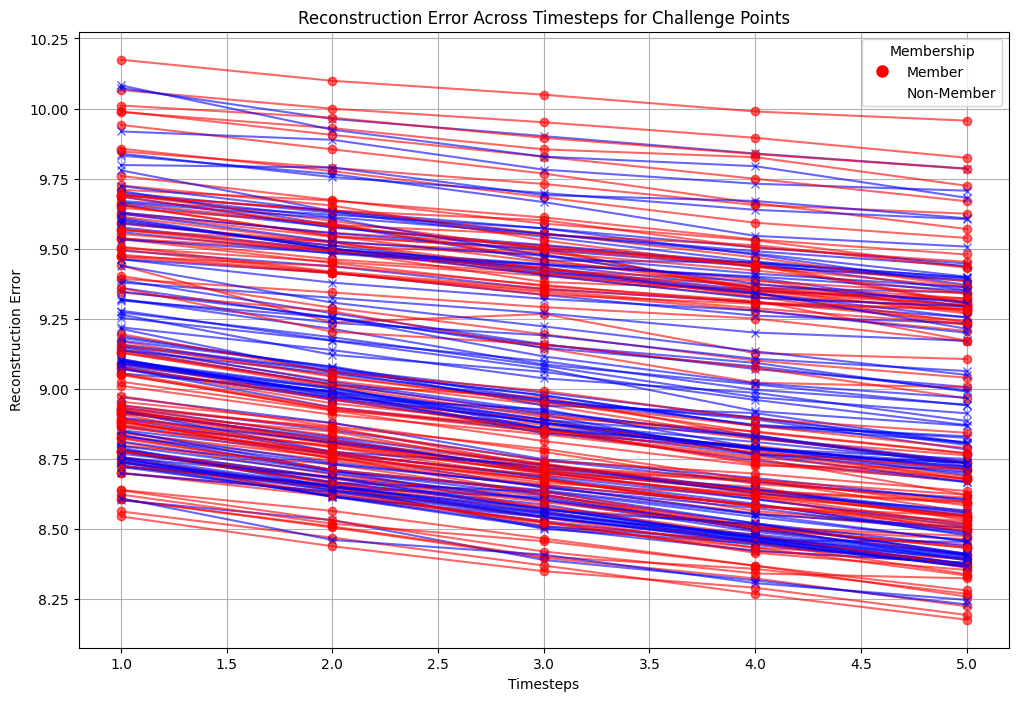

In [358]:
challenge_errors_multi = compute_timestep_errors(challenge_tensor, model, timesteps)
# Ensure challenge_errors_multi is a NumPy array
if isinstance(challenge_errors_multi, torch.Tensor):
    challenge_errors_multi_cpu = challenge_errors_multi.cpu().detach().numpy()
else:
    challenge_errors_multi_cpu = challenge_errors_multi

# Ensure challenge_ground_truth is a NumPy array
if isinstance(challenge_ground_truth, torch.Tensor):
    challenge_ground_truth_cpu = challenge_ground_truth.cpu().detach().numpy()
else:
    challenge_ground_truth_cpu = challenge_ground_truth

# Create the plot
plt.figure(figsize=(12, 8))

# Loop through each sample
for idx in range(challenge_errors_multi_cpu.shape[0]):  # Number of samples
    # Assign marker and color based on membership
    marker = 'o' if challenge_ground_truth_cpu[idx] == 1 else 'x'
    color = 'red' if challenge_ground_truth_cpu[idx] == 1 else 'blue'
    
    # Plot reconstruction error against timesteps for the current sample
    plt.plot(
        range(1, challenge_errors_multi_cpu.shape[1] + 1),  # X-axis: Timesteps
        challenge_errors_multi_cpu[idx, :],  # Y-axis: Errors across timesteps
        marker=marker,  # Use marker based on membership
        color=color,  # Use color based on membership
        alpha=0.6,  # Transparency for overlapping lines
        label=f"Sample {idx + 1}" if idx < 10 else "",  # Only label a few samples to avoid clutter
    )

# Add labels, legend, and title
plt.title("Reconstruction Error Across Timesteps for Challenge Points")
plt.xlabel("Timesteps")
plt.ylabel("Reconstruction Error")
plt.grid(True)

# Create a custom legend for membership
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Member'),
    Line2D([0], [0], marker='x', color='w', markerfacecolor='blue', markersize=10, label='Non-Member'),
]
plt.legend(handles=legend_elements, title="Membership", loc="upper right")

plt.show()


### Denoise fn

In [33]:
x = torch.tensor([1841.6846362997792,2,4,14.600000381469727,60423.310643235105,6,0,0.0]).to(device = 'cuda')
column_var = torch.tensor([ 2.6176e+05, 9.3693e-01, 2.5482e+00, 9.0376e+07,
    4.8698e+08, 7.0646e+00, 1.3100e+01, 6.8835e+14]).to(device = 'cuda')
column_std = torch.sqrt(column_var).to(device = 'cuda')
column_means = torch.tensor([ 1.4638e+03, 1.2178e+00, 2.4518e+00, 5.9199e+03,
    3.8463e+04, 3.3334e+00, 1.8213e+00, 1.2850e+07]).to(device= 'cuda')
t = 10
# Simulate the diffusion process


x_t = model.gaussian_q_sample(x_start=x, t=torch.tensor([t]).to(x.device))
x_t = (x_t - column_means)/column_std
x_recon = model._denoise_fn(x_t, torch.tensor([t]).to(x.device))
print(x)
print(x_t)
print(x_recon)


x = (x - column_means)/column_std 
 
print(x)
print(x_recon)

# Compute reconstruction error (e.g., L2 norm)
t_error = torch.norm(x - x_recon, p=2, dim=1)
print(t_error)

tensor([1.8417e+03, 2.0000e+00, 4.0000e+00, 1.4600e+01, 6.0423e+04, 6.0000e+00,
        0.0000e+00, 0.0000e+00], device='cuda:0')
tensor([ 0.7381,  0.7994,  0.9852, -0.6212,  0.9947,  1.0036, -0.5032, -0.4898],
       device='cuda:0')
tensor([[-0.1158, -0.4185,  0.8539,  3.4173, -7.3831, 14.1741, -5.3711,  4.4559]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([ 0.7386,  0.8081,  0.9699, -0.6212,  0.9951,  1.0033, -0.5032, -0.4898],
       device='cuda:0')
tensor([[-0.1158, -0.4185,  0.8539,  3.4173, -7.3831, 14.1741, -5.3711,  4.4559]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([17.6176], device='cuda:0', grad_fn=<NormBackward1>)


In [ ]:
16.1690